# Weak Convergence and Optimal Scaling of Random Walk Metropolis Algorithms

<div style="text-align: right"> Peng-Wei CHEN</div>

### Abstract
This paper provides a theoretical results for the best scaling proposal and the accept/reject ratios for the Metropolis Algorithm with certain conditions:
 1. Having the same distribution according to different coordinates ($f$)
 2. (A1) $\mathbb{E}_f \left[ \left( \frac{f'(X)}{f(X)}\right)^8 \right] = M < \infty$
 3. (A2) $\mathbb{E}_f \left[ \left( \frac{f''(X)}{f(X)}\right)^4 \right] < \infty$
 2. We suppose the random walk is chosen by a Gaussian proposal density.

The results show that for any coordinates of the resulting simulations, while the total-dimension tends to infinity, the one-dimensional process converges weakly to a Langevin diffusion. We can thus find the optimal rate by maximizing the speed measure of this Langevin equation. They propose an optimize acceptance rate at 23%. We can soften the first condition different distributions according to different coordinates ($f_i$ for each coordinate), while the independance and some inequalities should still be hold. The optimal acceptance rate is still 0.234.

### Algorithme

To be clearer, consider a n-dimension random variable $X^n$. Let the density function be 
$$ \pi_n(x^n) = \prod_{i=1}^n f(x^n_i) $$
and the proposal density as follows:
$$q_n(x^n, y^n) = \frac{1}{(2\pi\sigma^2_n)^{n/2}} exp\left\{  \frac{-1}{2\sigma^2_n} |y^n - x^n|^2 \right\} $$
which is a n-dimension Gaussian law with mean $= x^n$ and standard-type $ = \sigma_n^2$.


By taking the acceptance function
$$ \alpha(X^n_{m-1}, Y^n) = 1 \wedge \frac{\pi_n (Y^n)}{\pi_n (X^n_{m-1})} $$
we have thus the Metropolis algorithm for the random walk, where the deduced Markov chain is ergodic with respect to $\pi_n$.

### Theoretical results
The main result of this paper is to show that the best variance to choose is (the factor (n-1) can be replaced by (n))
$$ \sigma^2_n = \frac{l^2}{(n-1)}$$
where
$$ l = \frac{2.38}{\sqrt{I}} $$
and
$$ I = \mathbb{E}_f \left[ \left( \frac{f'(X)}{f(X)} \right)^2 \right] $$

### Interest while practicing
Under these conditions, it will be very easy to monitor if the step size ($\sigma_n$) here is at an adequate size. All we need to do is tuning the step size so that the acceptance rate rests around 23.4%. It is also possible to calculate the step size if we know the factor $I$. But this is not often the case.

### implementation

In [1]:
%matplotlib inline
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.stats import ks_1samp

np.random.seed(1)

We define the instance for the simulation with the following class:

In [2]:
class Metropolis:
    def __init__(self, n, m, l, f, DEBUG=False):
        self.n = n
        self.m = m
        self.l = l
        self.f = np.vectorize(f)
        self.DEBUG = DEBUG
    
    def __call__(self, l=None, X_0=None):
        self.run(l, X_0)
        return self
    
    def pi(self, x):
        return np.prod(self.f(x))
    
    def alpha(self, X_last, Y):
        return min(1, self.pi(Y) / self.pi(X_last))
    
    def run(self, l = None, X_0=None):
        # Initiation
        if l is None:
            n, m, l, pi, alpha = self.n, self.m, self.l, self.pi, self.alpha
        else:
            n, m, pi, alpha = self.n, self.m, self.pi, self.alpha
        sigma_n = np.sqrt(l ** 2 / (n-1))
        if X_0 is None:
            X_0 = np.random.normal(size=n)
        random_state = np.random.normal(size=(m, n))
        U = np.random.uniform(size=m)
        results = np.zeros(shape=(m+1, n))
        pi_x = np.zeros(m)
        results[0] = X_0
        accepted = 0
        accepted_rates = np.zeros(m)

        # Run Metropolis random walk algorithm.
        for i in tqdm(range(m)):
            # Proposal
            potential_next_y = results[i] + sigma_n * random_state[i]
            potential = alpha(results[i], potential_next_y)
            
            # Accept/Reject
            if U[i] < potential:
                results[i+1] = potential_next_y
                accepted += 1
            else:
                results[i+1] = results[i]
            if self.DEBUG and np.linalg.norm(results[i+1]) > 5:
                print(np.linalg.norm(results[i+1]), results[i], results[i+1], potential, pi(results[i]), pi(potential_next_y))

            pi_x[i] = pi(results[i])
            accepted_rates[i] = accepted / (i + 1)
            
        # Results
        #print("Accepted rate : {}".format(accepted / m))
        self.accepted_rate = accepted / m
        self.simulation = results
        self.pi_x = pi_x
        self.accepted_rates = accepted_rates
        return accepted / m, results, pi_x

    def plot_hist(self, bins_cut = 40, x_cut = 1000, bot = -5, top = 5, cdf_func=None):
        plt.hist(self.simulation[:, 0], bins=np.linspace(bot, top, bins_cut), density=True)
        x = np.linspace(bot, top, x_cut)
        plt.plot(x, [self.f(x_) for x_ in x])
        plt.xlabel("x")
        plt.ylabel("Density")
        plt.title("Histogram of the result distribution")
        plt.show()
        if cdf_func is not None:
            x = np.linspace(bot, top, x_cut)
            plt.hist(self.simulation[:, 0], bins=np.linspace(bot, top, bins_cut), cumulative=True, density=True)
            plt.plot(x, [cdf_func(x_) for x_ in x])
            plt.xlabel("x")
            plt.ylabel("cdf")
            plt.title("Cumulative function of the result distribution")
            plt.show()
            print(ks_1samp(self.simulation[:, 0], cdf_func))
    
    def plot_accepted_rate(self):
        plt.plot(self.accepted_rates[50:])
        plt.xlabel("Epochs")
        plt.ylabel("Acceptance rate")
        plt.title("Acceptance rate - Epochs\n last acceptance rate : {:.4f}".format(self.accepted_rates[-1]))
        plt.show()
        
    def check_langevin(self, f, f_der, l, I, cut=9):
        h = 2 * l * l * norm.cdf(-l * np.sqrt(I) / 2)
        U = self.simulation[:, 0]
        delta = 1 / self.n
        std = np.sqrt(h * delta)
        gauss_to_test = U[1:] - U[:-1] - h * f_der(U[:-1]) / 2 / f(U[:-1]) * delta

        plt.hist(gauss_to_test, bins=np.linspace(-0.5, 0.5, cut), density=True)
        plt.plot(np.linspace(-0.5, 0.5, 100), norm.pdf(x=np.linspace(-0.5, 0.5, 100), loc=0, scale=std))
        plt.xlabel("x")
        plt.ylabel("density")
        plt.title("Stochastic part distribution in Langevin SDE")
        plt.show()
        return gauss_to_test

We will test on gaussian distribution for $f$. In this case, we can calculate precisely the step size $\sigma_n$.

In [3]:
mu = 0
sigma = 1
# Best case
def I_cal(mu, sigma):
    return 1 / sigma ** 2 # For gaussian
    #return esp_f((f_derive(X) / f(X)) ** 2) over X

def f_gauss(x_i):
    return norm.pdf(x_i, loc=mu, scale=sigma)

cdf_func = norm.cdf

### Case n = 2

  0%|          | 0/10000 [00:00<?, ?it/s]

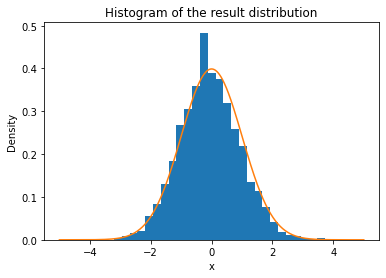

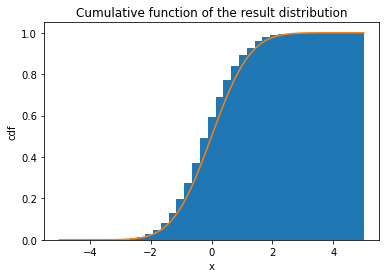

KstestResult(statistic=0.053270883910731426, pvalue=4.16295748036744e-25)


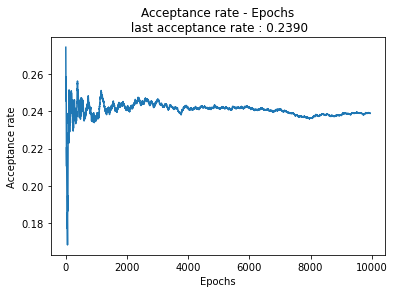

CPU times: user 7.79 s, sys: 219 ms, total: 8.01 s
Wall time: 7.73 s


In [4]:
%%time
I = I_cal(mu, sigma)
l = 2.38 / np.sqrt(I)
instance = Metropolis(n=2, m=int(1e4), l=l, f=f_gauss)()
instance.plot_hist(cdf_func =cdf_func)
instance.plot_accepted_rate()

The result is not satisfactory. But the convergence is also shown for n tends to infinity, and we have $n = 2$ here.

### Case with higher dimensions

  0%|          | 0/10000 [00:00<?, ?it/s]

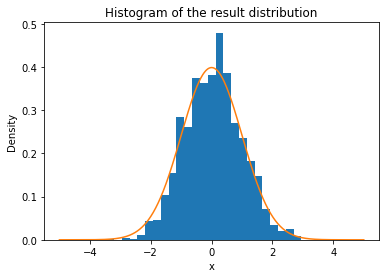

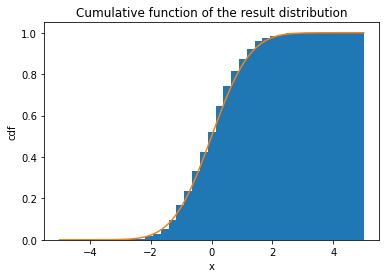

KstestResult(statistic=0.033380710415718606, pvalue=4.07163631912295e-10)


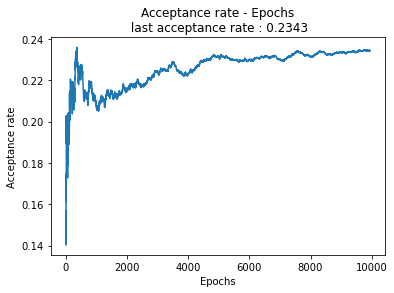

CPU times: user 27.5 s, sys: 861 ms, total: 28.3 s
Wall time: 27.1 s


In [5]:
%%time
I = I_cal(mu, sigma)
l = 2.38 / np.sqrt(I)
instance = Metropolis(n=10, m=int(1e4), l=l, f=f_gauss)()
instance.plot_hist(cdf_func =cdf_func)
instance.plot_accepted_rate()

  0%|          | 0/10000 [00:00<?, ?it/s]

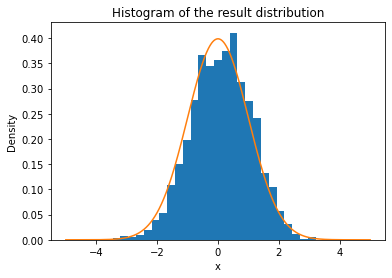

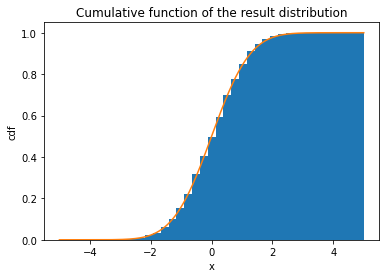

KstestResult(statistic=0.061749445607505615, pvalue=1.3588994386369676e-33)


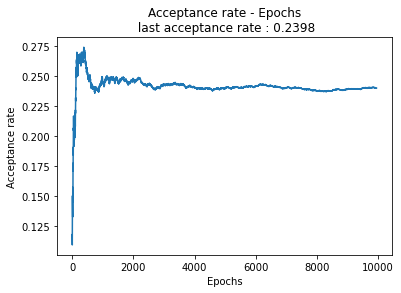

CPU times: user 1min 14s, sys: 21.2 s, total: 1min 35s
Wall time: 1min 11s


In [6]:
%%time
I = I_cal(mu, sigma)
l = 2.38 / np.sqrt(I)
instance = Metropolis(n=20, m=int(1e4), l=l, f=f_gauss)()
instance.plot_hist(cdf_func =cdf_func)
instance.plot_accepted_rate()

  0%|          | 0/10000 [00:00<?, ?it/s]

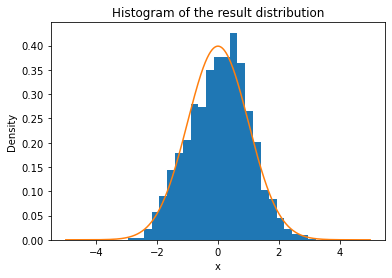

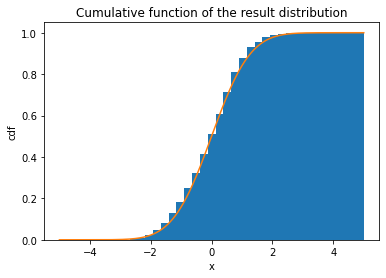

KstestResult(statistic=0.04879286411231165, pvalue=3.9396107904474356e-21)


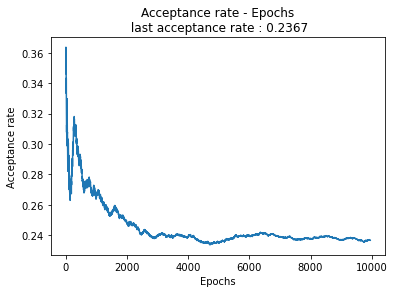

CPU times: user 2min 23s, sys: 59.7 s, total: 3min 22s
Wall time: 2min 20s


In [7]:
%%time
I = I_cal(mu, sigma)
l = 2.38 / np.sqrt(I)
instance = Metropolis(n=32, m=int(1e4), l=l, f=f_gauss)()
instance.plot_hist(cdf_func =cdf_func)
instance.plot_accepted_rate()

In [8]:
print(l)

2.38


We have $l = 2.38$ while the mean and the variance of the function $f$ are 1. The acceptance rate converge to 0.234 while n is greater.

### Gumbel distribution
We are going to test the algorithm on gumbel distribution.

In [9]:
from scipy.stats import gumbel_r
# Best case
def f_gumbel(x_i):
    return gumbel_r.pdf(x_i)
cdf_func = gumbel_r.cdf

  0%|          | 0/10000 [00:00<?, ?it/s]

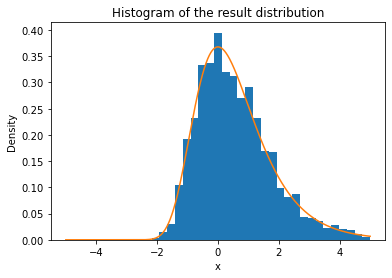

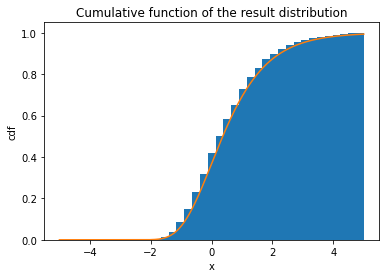

KstestResult(statistic=0.023212921325651892, pvalue=4.102807428664777e-05)


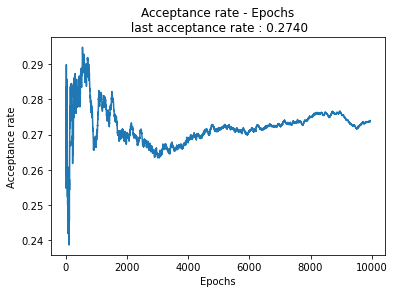

CPU times: user 14.9 s, sys: 6.79 s, total: 21.7 s
Wall time: 14.9 s


In [10]:
%%time
I = 1
l = 2.38 / np.sqrt(I)
instance = Metropolis(n=2, m=int(1e4), l=l, f=f_gumbel)()
instance.plot_hist(cdf_func =cdf_func)
instance.plot_accepted_rate()

  0%|          | 0/10000 [00:00<?, ?it/s]

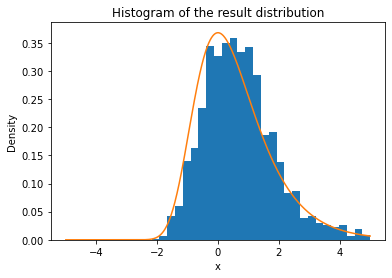

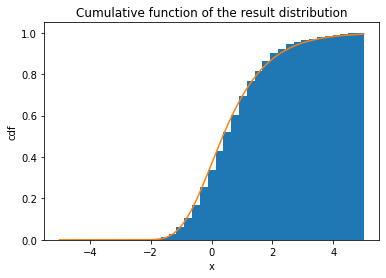

KstestResult(statistic=0.08470126355308893, pvalue=7.188789850289983e-63)


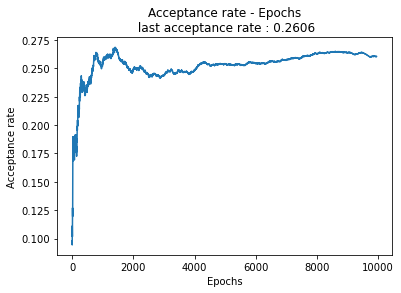

CPU times: user 1min 7s, sys: 28.5 s, total: 1min 35s
Wall time: 1min 6s


In [11]:
%%time
I = 1
l = 2.38 / np.sqrt(I)
instance = Metropolis(n=15, m=int(1e4), l=l, f=f_gumbel)()
instance.plot_hist(cdf_func =cdf_func)
instance.plot_accepted_rate()

  0%|          | 0/10000 [00:00<?, ?it/s]

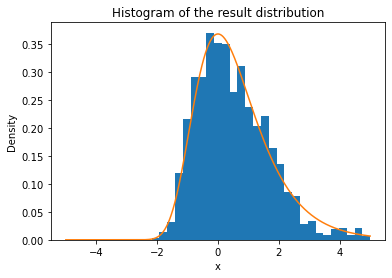

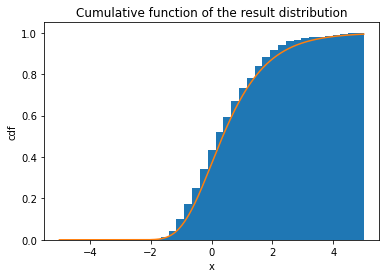

KstestResult(statistic=0.0258336608588339, pvalue=3.1294356177073614e-06)


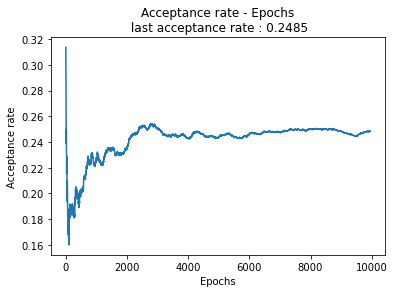

CPU times: user 2min 5s, sys: 47.7 s, total: 2min 52s
Wall time: 2min 3s


In [12]:
%%time
I = 1
l = 2.38 / np.sqrt(I)
instance = Metropolis(n=32, m=int(1e4), l=l, f=f_gumbel)()
instance.plot_hist(cdf_func =cdf_func)
instance.plot_accepted_rate()

  0%|          | 0/10000 [00:00<?, ?it/s]

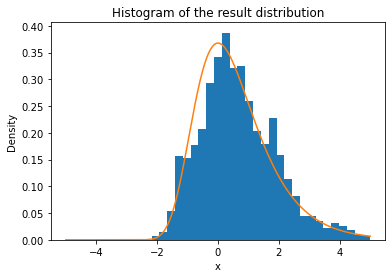

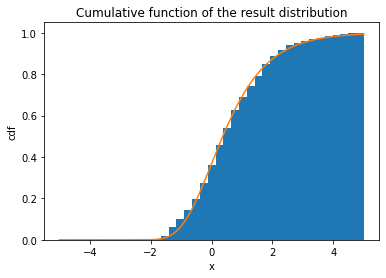

KstestResult(statistic=0.05682004111988426, pvalue=1.6583771933067347e-28)


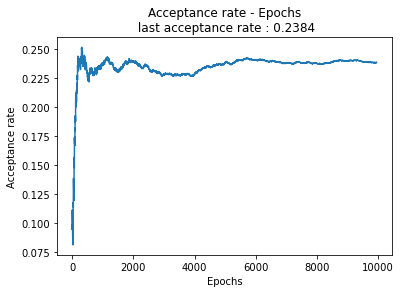

CPU times: user 4min 35s, sys: 2min 15s, total: 6min 50s
Wall time: 4min 37s


In [13]:
%%time
I = 1
l = 2.38 / np.sqrt(I)
instance = Metropolis(n=64, m=int(1e4), l=l, f=f_gumbel)()
instance.plot_hist(cdf_func =cdf_func)
instance.plot_accepted_rate()

We do have a way to "precalculate" the step size so that the acceptance rate is at 23.4% (this is not true in general, since we don't have the value of $\mathbb{E}_f [(\frac{f'(x)}{f(x)})^2]$). However, the result simulations seem "correct" but we can not meet the Kolmogorov-Smirnov test in both Gumbel and Gaussian distributions under 95% confidence.

In the article, we also show that by defining $U^n_t = X^n_{[nt], 1}$ (The first component of $X^n_{[nt]}$), we have :
$$
dU_t = (h(l))^{\frac{1}{2}} dB_t + h(l) \frac{f'(U_t)}{2f(U_t)} dt
$$
where 
$$
h(l) = 2l^2 \Phi\left( -\frac{l\sqrt{I}}{2} \right)
$$
By discretisation ($\delta = 1/n$), we have
$$
\Delta U_{k\delta} = \sqrt{h(l)} (B_{(k + 1)\delta} - B_{k\delta}) + h(l)\frac{f'(U_{k\delta})}{2f(U_{k\delta})}((k+1)\delta - k\delta)
$$
Finally, we have
$$
\Delta U_{k\delta} - h(l)\frac{f'(U_{k\delta})}{2f(U_{k\delta})}\delta \sim N(0, h(l)\delta)
$$

In [14]:
def f_gumbel_der(x):
    return -np.exp(-2 * x - np.exp(-x)) * (np.exp(x) - 1)

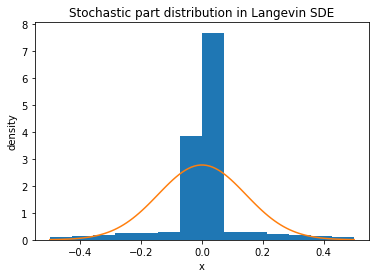

array([0.00394897, 0.00394897, 0.00394897, ..., 0.20998975, 0.00541898,
       0.00541898])

In [15]:
instance.check_langevin(f = f_gumbel, f_der = f_gumbel_der, l = l, I = I, cut=15)

  0%|          | 0/10000 [00:00<?, ?it/s]

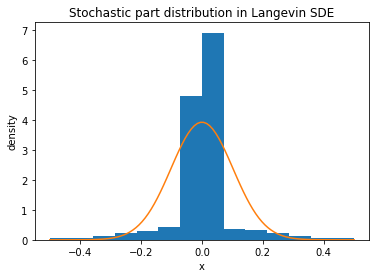

CPU times: user 7min 47s, sys: 3min, total: 10min 48s
Wall time: 7min 43s


array([-0.01870977, -0.01870977,  0.12777998, ..., -0.00036202,
       -0.00036202, -0.00036202])

In [16]:
%%time
I = 1
l = 2.38 / np.sqrt(I)
instance = Metropolis(n=128, m=int(1e4), l=l, f=f_gumbel)()
instance.check_langevin(f = f_gumbel, f_der = f_gumbel_der, l=l, I=I, cut=15)

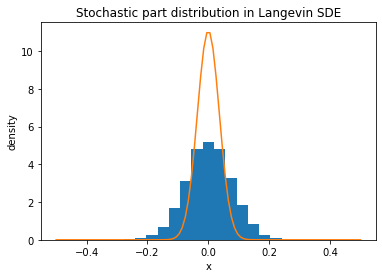

array([-0.12165772, -0.09222254,  0.06716815, ...,  0.02611345,
       -0.24367429,  0.12718374])

In [19]:
%%time
I = 1
l = 2.38 / np.sqrt(I)
instance = Metropolis(n=1024, m=int(1e4), l=l, f=f_gumbel)()
instance.check_langevin(f = f_gumbel, f_der = f_gumbel_der, l=l, I=I, cut=28)

Finally, for $n = 1024$, we still don't observe a good shape, but the distribution become nearer than small n.